In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_targets_t1t2_normalized_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 1380)
(734160, 1)
validation
(101248, 1380)
(101248, 1)
test
(100432, 1380)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1380)]            0         


 dense (Dense)               (None, 1024)              1414144   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2103297 (8.02 MB)


Trainable params: 2103297 (8.02 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:24 - loss: 0.3780 - STD: 9.6157e-05 - MAE: 0.6049

 4/74 [>.............................] - ETA: 1s - loss: 0.1670 - STD: 3.7193e-04 - MAE: 0.3496  

 6/74 [=>............................] - ETA: 1s - loss: 0.1182 - STD: 2.9153e-04 - MAE: 0.2645

 8/74 [==>...........................] - ETA: 1s - loss: 0.0980 - STD: 2.2687e-04 - MAE: 0.2383

10/74 [===>..........................] - ETA: 1s - loss: 0.0873 - STD: 1.8318e-04 - MAE: 0.2264

12/74 [===>..........................] - ETA: 1s - loss: 0.0802 - STD: 1.5366e-04 - MAE: 0.2190

14/74 [====>.........................] - ETA: 1s - loss: 0.0750 - STD: 1.3302e-04 - MAE: 0.2132

16/74 [=====>........................] - ETA: 1s - loss: 0.0706 - STD: 1.1796e-04 - MAE: 0.2076

18/74 [======>.......................] - ETA: 1s - loss: 0.0666 - STD: 1.0628e-04 - MAE: 0.2010

20/74 [=======>......................] - ETA: 1s - loss: 0.0625 - STD: 9.7110e-05 - MAE: 0.1927

22/74 [=======>......................] - ETA: 1s - loss: 0.0584 - STD: 8.9690e-05 - MAE: 0.1825

24/74 [========>.....................] - ETA: 1s - loss: 0.0545 - STD: 8.3317e-05 - MAE: 0.1724

26/74 [=========>....................] - ETA: 1s - loss: 0.0514 - STD: 7.8057e-05 - MAE: 0.1659

28/74 [==========>...................] - ETA: 1s - loss: 0.0489 - STD: 7.3498e-05 - MAE: 0.1621

30/74 [===========>..................] - ETA: 1s - loss: 0.0468 - STD: 6.9222e-05 - MAE: 0.1593

32/74 [===========>..................] - ETA: 1s - loss: 0.0449 - STD: 6.5324e-05 - MAE: 0.1562

33/74 [============>.................] - ETA: 1s - loss: 0.0445 - STD: 6.3586e-05 - MAE: 0.1543

36/74 [=============>................] - ETA: 1s - loss: 0.0418 - STD: 5.8889e-05 - MAE: 0.1476

39/74 [==============>...............] - ETA: 1s - loss: 0.0395 - STD: 5.4800e-05 - MAE: 0.1409

41/74 [===============>..............] - ETA: 1s - loss: 0.0382 - STD: 5.2364e-05 - MAE: 0.1370

43/74 [================>.............] - ETA: 1s - loss: 0.0371 - STD: 5.0128e-05 - MAE: 0.1336

45/74 [=================>............] - ETA: 1s - loss: 0.0360 - STD: 4.8075e-05 - MAE: 0.1303

47/74 [==================>...........] - ETA: 1s - loss: 0.0350 - STD: 4.6286e-05 - MAE: 0.1275

49/74 [==================>...........] - ETA: 1s - loss: 0.0341 - STD: 4.4678e-05 - MAE: 0.1251

51/74 [===================>..........] - ETA: 0s - loss: 0.0332 - STD: 4.3200e-05 - MAE: 0.1233

53/74 [====================>.........] - ETA: 0s - loss: 0.0324 - STD: 4.1815e-05 - MAE: 0.1217

55/74 [=====================>........] - ETA: 0s - loss: 0.0317 - STD: 4.0536e-05 - MAE: 0.1203

57/74 [======================>.......] - ETA: 0s - loss: 0.0310 - STD: 3.9316e-05 - MAE: 0.1188

59/74 [======================>.......] - ETA: 0s - loss: 0.0304 - STD: 3.8198e-05 - MAE: 0.1172

61/74 [=======================>......] - ETA: 0s - loss: 0.0298 - STD: 3.7145e-05 - MAE: 0.1156

63/74 [========================>.....] - ETA: 0s - loss: 0.0292 - STD: 3.6144e-05 - MAE: 0.1140

65/74 [=========================>....] - ETA: 0s - loss: 0.0287 - STD: 3.5218e-05 - MAE: 0.1125

67/74 [==========================>...] - ETA: 0s - loss: 0.0282 - STD: 3.4289e-05 - MAE: 0.1110

69/74 [==========================>...] - ETA: 0s - loss: 0.0277 - STD: 3.3472e-05 - MAE: 0.1097

71/74 [===========================>..] - ETA: 0s - loss: 0.0273 - STD: 3.2743e-05 - MAE: 0.1085

73/74 [============================>.] - ETA: 0s - loss: 0.0268 - STD: 3.2016e-05 - MAE: 0.1075

74/74 [==============================] - 5s 49ms/step - loss: 0.0266 - STD: 3.1678e-05 - MAE: 0.1070 - val_loss: 0.0145 - val_STD: 2.0156e-06 - val_MAE: 0.0777


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0119 - STD: 5.5074e-06 - MAE: 0.0733

 3/74 [>.............................] - ETA: 2s - loss: 0.0121 - STD: 5.5741e-06 - MAE: 0.0732

 5/74 [=>............................] - ETA: 2s - loss: 0.0120 - STD: 6.2311e-06 - MAE: 0.0726

 8/74 [==>...........................] - ETA: 1s - loss: 0.0120 - STD: 5.9687e-06 - MAE: 0.0717

10/74 [===>..........................] - ETA: 1s - loss: 0.0121 - STD: 5.9573e-06 - MAE: 0.0710

12/74 [===>..........................] - ETA: 1s - loss: 0.0121 - STD: 6.0257e-06 - MAE: 0.0704

14/74 [====>.........................] - ETA: 1s - loss: 0.0120 - STD: 6.0106e-06 - MAE: 0.0699

16/74 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 6.0263e-06 - MAE: 0.0697

18/74 [======>.......................] - ETA: 1s - loss: 0.0121 - STD: 5.9521e-06 - MAE: 0.0696

20/74 [=======>......................] - ETA: 1s - loss: 0.0121 - STD: 5.9675e-06 - MAE: 0.0697

22/74 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 6.0113e-06 - MAE: 0.0697

24/74 [========>.....................] - ETA: 1s - loss: 0.0120 - STD: 5.9999e-06 - MAE: 0.0698

26/74 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 6.0422e-06 - MAE: 0.0698

28/74 [==========>...................] - ETA: 1s - loss: 0.0121 - STD: 6.0441e-06 - MAE: 0.0698

30/74 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 6.1184e-06 - MAE: 0.0698

32/74 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 6.2723e-06 - MAE: 0.0697

34/74 [============>.................] - ETA: 1s - loss: 0.0121 - STD: 6.3135e-06 - MAE: 0.0697

36/74 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 6.2921e-06 - MAE: 0.0696

38/74 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 6.2255e-06 - MAE: 0.0696

40/74 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 6.1754e-06 - MAE: 0.0696

42/74 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 6.1077e-06 - MAE: 0.0696

44/74 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 6.0423e-06 - MAE: 0.0696

46/74 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 6.0626e-06 - MAE: 0.0696

48/74 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 6.0909e-06 - MAE: 0.0696

50/74 [===================>..........] - ETA: 0s - loss: 0.0120 - STD: 6.1249e-06 - MAE: 0.0696

52/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 6.1566e-06 - MAE: 0.0696

54/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 6.1191e-06 - MAE: 0.0696

56/74 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 6.1159e-06 - MAE: 0.0695

58/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 6.1104e-06 - MAE: 0.0695

60/74 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 6.1217e-06 - MAE: 0.0694

62/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 6.1142e-06 - MAE: 0.0694

64/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 6.1040e-06 - MAE: 0.0694

66/74 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 6.1133e-06 - MAE: 0.0694

68/74 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 6.1098e-06 - MAE: 0.0694

70/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 6.0959e-06 - MAE: 0.0694

72/74 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 6.0755e-06 - MAE: 0.0694

74/74 [==============================] - ETA: 0s - loss: 0.0120 - STD: 6.0632e-06 - MAE: 0.0693

74/74 [==============================] - 3s 37ms/step - loss: 0.0120 - STD: 6.0632e-06 - MAE: 0.0693 - val_loss: 0.0145 - val_STD: 2.1109e-06 - val_MAE: 0.0729


Epoch 3/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0124 - STD: 6.2678e-06 - MAE: 0.0695

 3/74 [>.............................] - ETA: 2s - loss: 0.0119 - STD: 6.5428e-06 - MAE: 0.0685

 5/74 [=>............................] - ETA: 2s - loss: 0.0120 - STD: 5.7373e-06 - MAE: 0.0687

 7/74 [=>............................] - ETA: 2s - loss: 0.0120 - STD: 6.0264e-06 - MAE: 0.0688

 9/74 [==>...........................] - ETA: 2s - loss: 0.0120 - STD: 6.1614e-06 - MAE: 0.0689

11/74 [===>..........................] - ETA: 2s - loss: 0.0120 - STD: 6.0044e-06 - MAE: 0.0689

13/74 [====>.........................] - ETA: 2s - loss: 0.0120 - STD: 6.1849e-06 - MAE: 0.0691

15/74 [=====>........................] - ETA: 1s - loss: 0.0120 - STD: 6.3161e-06 - MAE: 0.0690

17/74 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 6.0549e-06 - MAE: 0.0692

19/74 [======>.......................] - ETA: 1s - loss: 0.0121 - STD: 6.1173e-06 - MAE: 0.0692

21/74 [=======>......................] - ETA: 1s - loss: 0.0121 - STD: 6.2444e-06 - MAE: 0.0693

23/74 [========>.....................] - ETA: 1s - loss: 0.0121 - STD: 6.1798e-06 - MAE: 0.0693

25/74 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 6.1700e-06 - MAE: 0.0694

28/74 [==========>...................] - ETA: 1s - loss: 0.0121 - STD: 6.1656e-06 - MAE: 0.0695

30/74 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 6.2819e-06 - MAE: 0.0695

32/74 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 6.3302e-06 - MAE: 0.0695

34/74 [============>.................] - ETA: 1s - loss: 0.0121 - STD: 6.3073e-06 - MAE: 0.0694

36/74 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 6.2974e-06 - MAE: 0.0693

38/74 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 6.3155e-06 - MAE: 0.0693

40/74 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 6.3621e-06 - MAE: 0.0692

42/74 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 6.4441e-06 - MAE: 0.0692

44/74 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 6.5392e-06 - MAE: 0.0692

46/74 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 6.6501e-06 - MAE: 0.0692

48/74 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 6.6477e-06 - MAE: 0.0692

50/74 [===================>..........] - ETA: 0s - loss: 0.0120 - STD: 6.6814e-06 - MAE: 0.0691

52/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 6.6619e-06 - MAE: 0.0691

54/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 6.6922e-06 - MAE: 0.0691

56/74 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 6.7317e-06 - MAE: 0.0691

58/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 6.7929e-06 - MAE: 0.0691

60/74 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 6.9121e-06 - MAE: 0.0691

62/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 6.9926e-06 - MAE: 0.0691

64/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 7.0550e-06 - MAE: 0.0691

66/74 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 7.0873e-06 - MAE: 0.0691

68/74 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 7.1159e-06 - MAE: 0.0691

70/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 7.2123e-06 - MAE: 0.0692

72/74 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 7.3277e-06 - MAE: 0.0692

74/74 [==============================] - ETA: 0s - loss: 0.0120 - STD: 7.4374e-06 - MAE: 0.0692

74/74 [==============================] - 3s 38ms/step - loss: 0.0120 - STD: 7.4374e-06 - MAE: 0.0692 - val_loss: 0.0145 - val_STD: 6.3023e-06 - val_MAE: 0.0741


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0125 - STD: 1.0413e-05 - MAE: 0.0709

 3/74 [>.............................] - ETA: 2s - loss: 0.0123 - STD: 9.2249e-06 - MAE: 0.0703

 5/74 [=>............................] - ETA: 2s - loss: 0.0121 - STD: 9.8567e-06 - MAE: 0.0699

 7/74 [=>............................] - ETA: 2s - loss: 0.0122 - STD: 1.0050e-05 - MAE: 0.0700

 9/74 [==>...........................] - ETA: 2s - loss: 0.0120 - STD: 1.0148e-05 - MAE: 0.0696

11/74 [===>..........................] - ETA: 2s - loss: 0.0120 - STD: 1.0198e-05 - MAE: 0.0695

13/74 [====>.........................] - ETA: 1s - loss: 0.0121 - STD: 1.0025e-05 - MAE: 0.0695

15/74 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 9.9926e-06 - MAE: 0.0694

17/74 [=====>........................] - ETA: 1s - loss: 0.0120 - STD: 1.0214e-05 - MAE: 0.0692

19/74 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 1.0422e-05 - MAE: 0.0693

21/74 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 1.0496e-05 - MAE: 0.0693

23/74 [========>.....................] - ETA: 1s - loss: 0.0120 - STD: 1.0584e-05 - MAE: 0.0693

25/74 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 1.0564e-05 - MAE: 0.0692

27/74 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 1.0401e-05 - MAE: 0.0691

29/74 [==========>...................] - ETA: 1s - loss: 0.0120 - STD: 1.0212e-05 - MAE: 0.0691

31/74 [===========>..................] - ETA: 1s - loss: 0.0120 - STD: 1.0287e-05 - MAE: 0.0691

33/74 [============>.................] - ETA: 1s - loss: 0.0120 - STD: 1.0211e-05 - MAE: 0.0692

35/74 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 1.0093e-05 - MAE: 0.0693

37/74 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 9.9892e-06 - MAE: 0.0694

39/74 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 9.9382e-06 - MAE: 0.0694

41/74 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 1.0015e-05 - MAE: 0.0694

43/74 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 9.9862e-06 - MAE: 0.0694

45/74 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 1.0026e-05 - MAE: 0.0693

47/74 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 1.0095e-05 - MAE: 0.0693

49/74 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 1.0036e-05 - MAE: 0.0694

51/74 [===================>..........] - ETA: 0s - loss: 0.0120 - STD: 9.9940e-06 - MAE: 0.0694

53/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 9.9391e-06 - MAE: 0.0694

55/74 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 9.9441e-06 - MAE: 0.0694

57/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 9.9870e-06 - MAE: 0.0693

59/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 1.0005e-05 - MAE: 0.0693

61/74 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 1.0018e-05 - MAE: 0.0693

63/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 1.0080e-05 - MAE: 0.0693

65/74 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 1.0114e-05 - MAE: 0.0693

68/74 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 1.0066e-05 - MAE: 0.0693

70/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 1.0071e-05 - MAE: 0.0693

72/74 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 1.0041e-05 - MAE: 0.0693

74/74 [==============================] - ETA: 0s - loss: 0.0120 - STD: 1.0118e-05 - MAE: 0.0692

74/74 [==============================] - 3s 37ms/step - loss: 0.0120 - STD: 1.0118e-05 - MAE: 0.0692 - val_loss: 0.0145 - val_STD: 9.6833e-06 - val_MAE: 0.0723


Epoch 5/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0128 - STD: 1.3344e-05 - MAE: 0.0699

 3/74 [>.............................] - ETA: 2s - loss: 0.0122 - STD: 1.3220e-05 - MAE: 0.0683

 5/74 [=>............................] - ETA: 2s - loss: 0.0120 - STD: 1.2592e-05 - MAE: 0.0682

 7/74 [=>............................] - ETA: 2s - loss: 0.0121 - STD: 1.1568e-05 - MAE: 0.0688

 9/74 [==>...........................] - ETA: 2s - loss: 0.0121 - STD: 1.1187e-05 - MAE: 0.0691

11/74 [===>..........................] - ETA: 2s - loss: 0.0121 - STD: 1.0950e-05 - MAE: 0.0693

13/74 [====>.........................] - ETA: 1s - loss: 0.0121 - STD: 1.0708e-05 - MAE: 0.0694

15/74 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 1.0590e-05 - MAE: 0.0694

17/74 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 1.0553e-05 - MAE: 0.0693

19/74 [======>.......................] - ETA: 1s - loss: 0.0121 - STD: 1.0597e-05 - MAE: 0.0693

21/74 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 1.0758e-05 - MAE: 0.0691

23/74 [========>.....................] - ETA: 1s - loss: 0.0120 - STD: 1.0738e-05 - MAE: 0.0690

25/74 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 1.0890e-05 - MAE: 0.0690

27/74 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 1.0899e-05 - MAE: 0.0690

29/74 [==========>...................] - ETA: 1s - loss: 0.0120 - STD: 1.0856e-05 - MAE: 0.0691

31/74 [===========>..................] - ETA: 1s - loss: 0.0120 - STD: 1.0955e-05 - MAE: 0.0691

33/74 [============>.................] - ETA: 1s - loss: 0.0120 - STD: 1.1095e-05 - MAE: 0.0691

35/74 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 1.1194e-05 - MAE: 0.0690

37/74 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 1.1356e-05 - MAE: 0.0690

39/74 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 1.1446e-05 - MAE: 0.0690

41/74 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 1.1616e-05 - MAE: 0.0691

43/74 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 1.1824e-05 - MAE: 0.0692

45/74 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 1.2036e-05 - MAE: 0.0692

47/74 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 1.2099e-05 - MAE: 0.0692

49/74 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 1.2154e-05 - MAE: 0.0691

52/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 1.2278e-05 - MAE: 0.0691

54/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 1.2401e-05 - MAE: 0.0691

56/74 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 1.2494e-05 - MAE: 0.0692

58/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 1.2578e-05 - MAE: 0.0692

60/74 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 1.2735e-05 - MAE: 0.0692

62/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 1.2879e-05 - MAE: 0.0692

64/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 1.2974e-05 - MAE: 0.0692

66/74 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 1.3108e-05 - MAE: 0.0692

68/74 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 1.3181e-05 - MAE: 0.0692

70/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 1.3266e-05 - MAE: 0.0692

72/74 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 1.3413e-05 - MAE: 0.0692

74/74 [==============================] - ETA: 0s - loss: 0.0120 - STD: 1.3552e-05 - MAE: 0.0692

74/74 [==============================] - 3s 36ms/step - loss: 0.0120 - STD: 1.3552e-05 - MAE: 0.0692 - val_loss: 0.0145 - val_STD: 1.4246e-05 - val_MAE: 0.0729


Epoch 6/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0125 - STD: 1.8640e-05 - MAE: 0.0697

 3/74 [>.............................] - ETA: 2s - loss: 0.0124 - STD: 1.8330e-05 - MAE: 0.0699

 5/74 [=>............................] - ETA: 2s - loss: 0.0122 - STD: 1.8298e-05 - MAE: 0.0698

 7/74 [=>............................] - ETA: 2s - loss: 0.0122 - STD: 1.8242e-05 - MAE: 0.0700

 9/74 [==>...........................] - ETA: 2s - loss: 0.0121 - STD: 1.8061e-05 - MAE: 0.0699

11/74 [===>..........................] - ETA: 2s - loss: 0.0120 - STD: 1.8246e-05 - MAE: 0.0696

13/74 [====>.........................] - ETA: 1s - loss: 0.0121 - STD: 1.8532e-05 - MAE: 0.0696

15/74 [=====>........................] - ETA: 1s - loss: 0.0120 - STD: 1.8587e-05 - MAE: 0.0694

17/74 [=====>........................] - ETA: 1s - loss: 0.0121 - STD: 1.8861e-05 - MAE: 0.0695

19/74 [======>.......................] - ETA: 1s - loss: 0.0121 - STD: 1.9104e-05 - MAE: 0.0695

21/74 [=======>......................] - ETA: 1s - loss: 0.0121 - STD: 1.9327e-05 - MAE: 0.0695

23/74 [========>.....................] - ETA: 1s - loss: 0.0120 - STD: 1.9391e-05 - MAE: 0.0694

25/74 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 1.9507e-05 - MAE: 0.0694

27/74 [=========>....................] - ETA: 1s - loss: 0.0121 - STD: 1.9554e-05 - MAE: 0.0694

29/74 [==========>...................] - ETA: 1s - loss: 0.0121 - STD: 1.9773e-05 - MAE: 0.0694

31/74 [===========>..................] - ETA: 1s - loss: 0.0121 - STD: 2.0159e-05 - MAE: 0.0695

33/74 [============>.................] - ETA: 1s - loss: 0.0121 - STD: 2.0534e-05 - MAE: 0.0695

35/74 [=============>................] - ETA: 1s - loss: 0.0121 - STD: 2.0746e-05 - MAE: 0.0695

37/74 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 2.1119e-05 - MAE: 0.0695

39/74 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 2.1509e-05 - MAE: 0.0695

41/74 [===============>..............] - ETA: 1s - loss: 0.0121 - STD: 2.1791e-05 - MAE: 0.0695

43/74 [================>.............] - ETA: 1s - loss: 0.0121 - STD: 2.2156e-05 - MAE: 0.0696

45/74 [=================>............] - ETA: 0s - loss: 0.0121 - STD: 2.2518e-05 - MAE: 0.0696

47/74 [==================>...........] - ETA: 0s - loss: 0.0121 - STD: 2.2740e-05 - MAE: 0.0696

49/74 [==================>...........] - ETA: 0s - loss: 0.0121 - STD: 2.2967e-05 - MAE: 0.0696

51/74 [===================>..........] - ETA: 0s - loss: 0.0121 - STD: 2.3200e-05 - MAE: 0.0695

53/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 2.3404e-05 - MAE: 0.0694

55/74 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 2.3543e-05 - MAE: 0.0693

57/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 2.3796e-05 - MAE: 0.0693

59/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 2.4181e-05 - MAE: 0.0693

61/74 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 2.4675e-05 - MAE: 0.0693

63/74 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 2.5116e-05 - MAE: 0.0693

65/74 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 2.5528e-05 - MAE: 0.0693

67/74 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 2.5861e-05 - MAE: 0.0693

69/74 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 2.6178e-05 - MAE: 0.0692

71/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 2.6574e-05 - MAE: 0.0692

74/74 [==============================] - ETA: 0s - loss: 0.0120 - STD: 2.7192e-05 - MAE: 0.0692

74/74 [==============================] - 3s 37ms/step - loss: 0.0120 - STD: 2.7192e-05 - MAE: 0.0692 - val_loss: 0.0145 - val_STD: 3.7677e-05 - val_MAE: 0.0737


Epoch 7/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0118 - STD: 4.5349e-05 - MAE: 0.0686

 3/74 [>.............................] - ETA: 2s - loss: 0.0118 - STD: 4.6538e-05 - MAE: 0.0686

 5/74 [=>............................] - ETA: 2s - loss: 0.0117 - STD: 4.6690e-05 - MAE: 0.0685

 7/74 [=>............................] - ETA: 2s - loss: 0.0117 - STD: 4.7691e-05 - MAE: 0.0683

 9/74 [==>...........................] - ETA: 2s - loss: 0.0117 - STD: 4.8631e-05 - MAE: 0.0680

11/74 [===>..........................] - ETA: 2s - loss: 0.0119 - STD: 4.9623e-05 - MAE: 0.0682

13/74 [====>.........................] - ETA: 1s - loss: 0.0119 - STD: 5.0294e-05 - MAE: 0.0684

15/74 [=====>........................] - ETA: 1s - loss: 0.0120 - STD: 5.1044e-05 - MAE: 0.0687

17/74 [=====>........................] - ETA: 1s - loss: 0.0120 - STD: 5.2042e-05 - MAE: 0.0691

19/74 [======>.......................] - ETA: 1s - loss: 0.0120 - STD: 5.2703e-05 - MAE: 0.0692

21/74 [=======>......................] - ETA: 1s - loss: 0.0120 - STD: 5.3853e-05 - MAE: 0.0692

23/74 [========>.....................] - ETA: 1s - loss: 0.0120 - STD: 5.4843e-05 - MAE: 0.0691

25/74 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 5.5836e-05 - MAE: 0.0691

27/74 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 5.6856e-05 - MAE: 0.0690

29/74 [==========>...................] - ETA: 1s - loss: 0.0120 - STD: 5.7943e-05 - MAE: 0.0690

31/74 [===========>..................] - ETA: 1s - loss: 0.0119 - STD: 5.8975e-05 - MAE: 0.0689

33/74 [============>.................] - ETA: 1s - loss: 0.0120 - STD: 6.0164e-05 - MAE: 0.0689

35/74 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 6.1495e-05 - MAE: 0.0690

37/74 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 6.2890e-05 - MAE: 0.0690

39/74 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 6.4269e-05 - MAE: 0.0691

41/74 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 6.5721e-05 - MAE: 0.0691

43/74 [================>.............] - ETA: 0s - loss: 0.0120 - STD: 6.7232e-05 - MAE: 0.0690

45/74 [=================>............] - ETA: 0s - loss: 0.0119 - STD: 6.8692e-05 - MAE: 0.0690

47/74 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 7.0329e-05 - MAE: 0.0689

49/74 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 7.2189e-05 - MAE: 0.0689

51/74 [===================>..........] - ETA: 0s - loss: 0.0120 - STD: 7.4179e-05 - MAE: 0.0690

53/74 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 7.6198e-05 - MAE: 0.0691

55/74 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 7.8304e-05 - MAE: 0.0691

57/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 8.0432e-05 - MAE: 0.0691

59/74 [======================>.......] - ETA: 0s - loss: 0.0120 - STD: 8.2658e-05 - MAE: 0.0690

61/74 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 8.5022e-05 - MAE: 0.0690

63/74 [========================>.....] - ETA: 0s - loss: 0.0119 - STD: 8.7509e-05 - MAE: 0.0690

66/74 [=========================>....] - ETA: 0s - loss: 0.0120 - STD: 9.1472e-05 - MAE: 0.0690

68/74 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 9.4346e-05 - MAE: 0.0691

70/74 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 9.7417e-05 - MAE: 0.0691

72/74 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 1.0060e-04 - MAE: 0.0691

74/74 [==============================] - ETA: 0s - loss: 0.0120 - STD: 1.0401e-04 - MAE: 0.0691

74/74 [==============================] - 3s 37ms/step - loss: 0.0120 - STD: 1.0401e-04 - MAE: 0.0691 - val_loss: 0.0145 - val_STD: 1.9182e-04 - val_MAE: 0.0746


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0117 - STD: 2.3203e-04 - MAE: 0.0696

 3/74 [>.............................] - ETA: 2s - loss: 0.0117 - STD: 2.3922e-04 - MAE: 0.0694

 5/74 [=>............................] - ETA: 2s - loss: 0.0118 - STD: 2.4549e-04 - MAE: 0.0690

 7/74 [=>............................] - ETA: 2s - loss: 0.0118 - STD: 2.5224e-04 - MAE: 0.0687

 9/74 [==>...........................] - ETA: 2s - loss: 0.0119 - STD: 2.6124e-04 - MAE: 0.0688

11/74 [===>..........................] - ETA: 2s - loss: 0.0118 - STD: 2.7040e-04 - MAE: 0.0688

13/74 [====>.........................] - ETA: 2s - loss: 0.0118 - STD: 2.8048e-04 - MAE: 0.0688

15/74 [=====>........................] - ETA: 1s - loss: 0.0119 - STD: 2.9073e-04 - MAE: 0.0688

17/74 [=====>........................] - ETA: 1s - loss: 0.0119 - STD: 3.0159e-04 - MAE: 0.0687

19/74 [======>.......................] - ETA: 1s - loss: 0.0119 - STD: 3.1394e-04 - MAE: 0.0688

21/74 [=======>......................] - ETA: 1s - loss: 0.0119 - STD: 3.2740e-04 - MAE: 0.0691

23/74 [========>.....................] - ETA: 1s - loss: 0.0119 - STD: 3.4107e-04 - MAE: 0.0692

25/74 [=========>....................] - ETA: 1s - loss: 0.0119 - STD: 3.5468e-04 - MAE: 0.0692

27/74 [=========>....................] - ETA: 1s - loss: 0.0119 - STD: 3.6869e-04 - MAE: 0.0691

29/74 [==========>...................] - ETA: 1s - loss: 0.0120 - STD: 3.8453e-04 - MAE: 0.0691

31/74 [===========>..................] - ETA: 1s - loss: 0.0120 - STD: 4.0260e-04 - MAE: 0.0691

33/74 [============>.................] - ETA: 1s - loss: 0.0120 - STD: 4.2222e-04 - MAE: 0.0692

35/74 [=============>................] - ETA: 1s - loss: 0.0120 - STD: 4.4282e-04 - MAE: 0.0693

37/74 [==============>...............] - ETA: 1s - loss: 0.0120 - STD: 4.6293e-04 - MAE: 0.0692

40/74 [===============>..............] - ETA: 1s - loss: 0.0120 - STD: 4.9524e-04 - MAE: 0.0690

42/74 [================>.............] - ETA: 1s - loss: 0.0120 - STD: 5.2155e-04 - MAE: 0.0690

44/74 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 5.5116e-04 - MAE: 0.0690

46/74 [=================>............] - ETA: 0s - loss: 0.0119 - STD: 5.8261e-04 - MAE: 0.0690

48/74 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 6.1486e-04 - MAE: 0.0691

50/74 [===================>..........] - ETA: 0s - loss: 0.0119 - STD: 6.4798e-04 - MAE: 0.0690

52/74 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 6.8628e-04 - MAE: 0.0690

54/74 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 7.3059e-04 - MAE: 0.0689

56/74 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 7.7981e-04 - MAE: 0.0689

58/74 [======================>.......] - ETA: 0s - loss: 0.0119 - STD: 8.3181e-04 - MAE: 0.0689

60/74 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 8.8759e-04 - MAE: 0.0688

62/74 [========================>.....] - ETA: 0s - loss: 0.0119 - STD: 9.5201e-04 - MAE: 0.0688

64/74 [========================>.....] - ETA: 0s - loss: 0.0119 - STD: 0.0010 - MAE: 0.0688    

66/74 [=========================>....] - ETA: 0s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0688

68/74 [==========================>...] - ETA: 0s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0687

70/74 [===========================>..] - ETA: 0s - loss: 0.0118 - STD: 0.0013 - MAE: 0.0687

72/74 [============================>.] - ETA: 0s - loss: 0.0118 - STD: 0.0014 - MAE: 0.0686

74/74 [==============================] - ETA: 0s - loss: 0.0118 - STD: 0.0015 - MAE: 0.0686

74/74 [==============================] - 3s 36ms/step - loss: 0.0118 - STD: 0.0015 - MAE: 0.0686 - val_loss: 0.0134 - val_STD: 0.0055 - val_MAE: 0.0723


Epoch 9/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0108 - STD: 0.0066 - MAE: 0.0667

 3/74 [>.............................] - ETA: 2s - loss: 0.0111 - STD: 0.0068 - MAE: 0.0669

 5/74 [=>............................] - ETA: 2s - loss: 0.0111 - STD: 0.0073 - MAE: 0.0669

 7/74 [=>............................] - ETA: 2s - loss: 0.0110 - STD: 0.0079 - MAE: 0.0665

 9/74 [==>...........................] - ETA: 2s - loss: 0.0110 - STD: 0.0084 - MAE: 0.0663

11/74 [===>..........................] - ETA: 1s - loss: 0.0109 - STD: 0.0090 - MAE: 0.0660

13/74 [====>.........................] - ETA: 1s - loss: 0.0108 - STD: 0.0098 - MAE: 0.0657

15/74 [=====>........................] - ETA: 1s - loss: 0.0106 - STD: 0.0105 - MAE: 0.0652

17/74 [=====>........................] - ETA: 1s - loss: 0.0106 - STD: 0.0113 - MAE: 0.0649

19/74 [======>.......................] - ETA: 1s - loss: 0.0104 - STD: 0.0122 - MAE: 0.0645

21/74 [=======>......................] - ETA: 1s - loss: 0.0103 - STD: 0.0131 - MAE: 0.0641

23/74 [========>.....................] - ETA: 1s - loss: 0.0101 - STD: 0.0141 - MAE: 0.0636

25/74 [=========>....................] - ETA: 1s - loss: 0.0100 - STD: 0.0152 - MAE: 0.0631

27/74 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 0.0164 - MAE: 0.0628

29/74 [==========>...................] - ETA: 1s - loss: 0.0097 - STD: 0.0175 - MAE: 0.0622

31/74 [===========>..................] - ETA: 1s - loss: 0.0096 - STD: 0.0188 - MAE: 0.0617

33/74 [============>.................] - ETA: 1s - loss: 0.0094 - STD: 0.0203 - MAE: 0.0613

35/74 [=============>................] - ETA: 1s - loss: 0.0093 - STD: 0.0215 - MAE: 0.0606

37/74 [==============>...............] - ETA: 1s - loss: 0.0091 - STD: 0.0232 - MAE: 0.0601

39/74 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.0245 - MAE: 0.0593

41/74 [===============>..............] - ETA: 1s - loss: 0.0087 - STD: 0.0263 - MAE: 0.0588

43/74 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 0.0278 - MAE: 0.0582

46/74 [=================>............] - ETA: 0s - loss: 0.0084 - STD: 0.0301 - MAE: 0.0573

48/74 [==================>...........] - ETA: 0s - loss: 0.0082 - STD: 0.0320 - MAE: 0.0568

50/74 [===================>..........] - ETA: 0s - loss: 0.0081 - STD: 0.0334 - MAE: 0.0561

52/74 [====================>.........] - ETA: 0s - loss: 0.0079 - STD: 0.0351 - MAE: 0.0556

54/74 [====================>.........] - ETA: 0s - loss: 0.0078 - STD: 0.0366 - MAE: 0.0550

56/74 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0381 - MAE: 0.0545

58/74 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0397 - MAE: 0.0540

60/74 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0411 - MAE: 0.0534

62/74 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0425 - MAE: 0.0530

64/74 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0437 - MAE: 0.0525

66/74 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0449 - MAE: 0.0520

68/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0462 - MAE: 0.0516

70/74 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0473 - MAE: 0.0511

72/74 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0484 - MAE: 0.0506

74/74 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0494 - MAE: 0.0502

74/74 [==============================] - 3s 36ms/step - loss: 0.0066 - STD: 0.0494 - MAE: 0.0502 - val_loss: 0.0035 - val_STD: 0.0747 - val_MAE: 0.0405


Epoch 10/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0874 - MAE: 0.0350

 3/74 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0878 - MAE: 0.0349

 5/74 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0895 - MAE: 0.0352

 7/74 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0889 - MAE: 0.0360

 9/74 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0887 - MAE: 0.0354

12/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0887 - MAE: 0.0361

14/74 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.0889 - MAE: 0.0358

16/74 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0892 - MAE: 0.0359

18/74 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0900 - MAE: 0.0359

20/74 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0897 - MAE: 0.0358

22/74 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0897 - MAE: 0.0363

24/74 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0903 - MAE: 0.0368

26/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0891 - MAE: 0.0372

28/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0900 - MAE: 0.0375

30/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0894 - MAE: 0.0374

32/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0900 - MAE: 0.0375

34/74 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0897 - MAE: 0.0373

36/74 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0904 - MAE: 0.0373

38/74 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0901 - MAE: 0.0371

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0905 - MAE: 0.0371

42/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0902 - MAE: 0.0370

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0905 - MAE: 0.0369

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0904 - MAE: 0.0368

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0907 - MAE: 0.0368

50/74 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0907 - MAE: 0.0366

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0909 - MAE: 0.0366

54/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0908 - MAE: 0.0365

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0910 - MAE: 0.0364

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0910 - MAE: 0.0363

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0912 - MAE: 0.0362

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0913 - MAE: 0.0361

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0915 - MAE: 0.0361

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0914 - MAE: 0.0360

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0915 - MAE: 0.0359

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0915 - MAE: 0.0358

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0916 - MAE: 0.0357

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0916 - MAE: 0.0357

74/74 [==============================] - 3s 36ms/step - loss: 0.0030 - STD: 0.0916 - MAE: 0.0357 - val_loss: 0.0030 - val_STD: 0.0797 - val_MAE: 0.0365


Epoch 11/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0329

 3/74 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0942 - MAE: 0.0329

 5/74 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0936 - MAE: 0.0331

 7/74 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0938 - MAE: 0.0329

 9/74 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0940 - MAE: 0.0329

11/74 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0330

13/74 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0330

15/74 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0944 - MAE: 0.0330

17/74 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0948 - MAE: 0.0331

19/74 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0948 - MAE: 0.0330

21/74 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0330

23/74 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0330

25/74 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0947 - MAE: 0.0330

27/74 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0331

29/74 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0330

31/74 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0331

33/74 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0330

35/74 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0331

37/74 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0330

39/74 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0330

41/74 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0330

43/74 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0330

45/74 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0330

47/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0329

49/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0329

51/74 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0329

53/74 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0329

56/74 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0952 - MAE: 0.0328

58/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0328

60/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0328

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0328

64/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0328

66/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0328

68/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0328

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0328

72/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0328

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0327

74/74 [==============================] - 3s 36ms/step - loss: 0.0025 - STD: 0.0953 - MAE: 0.0327 - val_loss: 0.0029 - val_STD: 0.0815 - val_MAE: 0.0349


Epoch 12/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0320

 3/74 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0323

 5/74 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0322

 7/74 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0322

 9/74 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0959 - MAE: 0.0321

11/74 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0962 - MAE: 0.0321

13/74 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0322

15/74 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0321

17/74 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0322

19/74 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0322

21/74 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0321

23/74 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0321

25/74 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0321

27/74 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0322

29/74 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0322

31/74 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0321

33/74 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0321

35/74 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0321

37/74 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0321

39/74 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0321

41/74 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0321

43/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0321

45/74 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0321

47/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0965 - MAE: 0.0321

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0320

51/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0320

53/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0320

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0320

57/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0321

59/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0321

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0321

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0962 - MAE: 0.0320

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0320

68/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0320

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0320

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0320

74/74 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0963 - MAE: 0.0320

74/74 [==============================] - 3s 35ms/step - loss: 0.0024 - STD: 0.0963 - MAE: 0.0320 - val_loss: 0.0035 - val_STD: 0.0837 - val_MAE: 0.0423


Epoch 13/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0987 - MAE: 0.0333

 3/74 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0943 - MAE: 0.0321

 5/74 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0958 - MAE: 0.0322

 7/74 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0323

 9/74 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0323

11/74 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0323

13/74 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0323

15/74 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0324

17/74 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0324

19/74 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0322

21/74 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0322

23/74 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0322

25/74 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0323

27/74 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0322

29/74 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0965 - MAE: 0.0322

31/74 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0322

33/74 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0322

35/74 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0321

37/74 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0965 - MAE: 0.0321

39/74 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0964 - MAE: 0.0320

41/74 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0965 - MAE: 0.0320

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0966 - MAE: 0.0320

45/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0320

47/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0966 - MAE: 0.0319

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0319

51/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0319

53/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0319

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0318

57/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0318

59/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0318

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0317

63/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0317

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0317

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0317

69/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0317

71/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0317

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0316

74/74 [==============================] - 3s 36ms/step - loss: 0.0024 - STD: 0.0969 - MAE: 0.0316 - val_loss: 0.0028 - val_STD: 0.0792 - val_MAE: 0.0352


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0905 - MAE: 0.0309

 3/74 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0937 - MAE: 0.0314

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0963 - MAE: 0.0313

 7/74 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0314

 9/74 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0968 - MAE: 0.0315

11/74 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0970 - MAE: 0.0315

13/74 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0314

15/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0314

17/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0314

19/74 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0313

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

23/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0312

25/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

27/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0312

29/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0312

31/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0311

33/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

35/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0311

37/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0311

40/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0311

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0311

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0311

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0311

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0311

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0311

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0311

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0311

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0312

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0312

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0312

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0312

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0312

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0312

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0312

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0312

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0312

74/74 [==============================] - 3s 36ms/step - loss: 0.0023 - STD: 0.0973 - MAE: 0.0312 - val_loss: 0.0034 - val_STD: 0.0845 - val_MAE: 0.0407


Epoch 15/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0311

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0309

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0310

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0312

 9/74 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0311

11/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0312

13/74 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0984 - MAE: 0.0315

15/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0314

17/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0315

19/74 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0316

21/74 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0316

23/74 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0317

25/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0318

27/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0317

29/74 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0317

31/74 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0317

33/74 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0317

35/74 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0317

37/74 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0317

39/74 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0317

41/74 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0316

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0316

45/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0316

47/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0315

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0315

51/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0315

53/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0315

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0314

57/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0314

59/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0314

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0314

63/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0313

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0313

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

69/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

71/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0313

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0312

74/74 [==============================] - 3s 36ms/step - loss: 0.0023 - STD: 0.0974 - MAE: 0.0312 - val_loss: 0.0028 - val_STD: 0.0824 - val_MAE: 0.0350


Epoch 16/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0306

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0307

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0306

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0968 - MAE: 0.0305

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0304

11/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

13/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0305

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0305

17/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0305

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0305

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0305

23/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0305

25/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0305

27/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0305

29/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0304

31/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0304

33/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0304

35/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0305

37/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0305

39/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0305

41/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0305

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0305

45/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0305

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

51/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0304

74/74 [==============================] - 3s 36ms/step - loss: 0.0023 - STD: 0.0979 - MAE: 0.0304 - val_loss: 0.0028 - val_STD: 0.0820 - val_MAE: 0.0349


Epoch 17/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0970 - MAE: 0.0296

 3/74 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0298

 5/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299

 7/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0301

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0302

11/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0302

13/74 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0302

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0302

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0302

20/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0302

22/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0303

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0303

26/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0304

28/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0304

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0304

32/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0303

34/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0304

36/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

38/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

40/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0305

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0305

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0305

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0304

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0304

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0304

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304

74/74 [==============================] - 3s 36ms/step - loss: 0.0023 - STD: 0.0981 - MAE: 0.0304 - val_loss: 0.0027 - val_STD: 0.0805 - val_MAE: 0.0343


Epoch 18/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0923 - MAE: 0.0297

 3/74 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0303

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0307

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0306

 9/74 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0308

11/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0307

14/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

16/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

18/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0306

20/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0306

22/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0306

24/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0305

26/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306

28/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0305

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0305

32/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0304

34/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0304

36/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0304

38/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

40/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0304

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0304

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0303

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0303

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0303

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0303

74/74 [==============================] - 3s 35ms/step - loss: 0.0022 - STD: 0.0982 - MAE: 0.0303 - val_loss: 0.0034 - val_STD: 0.0842 - val_MAE: 0.0412


Epoch 19/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0309

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0306

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0304

 7/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302

11/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

13/74 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

23/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0300

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0299

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0299

31/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0299

33/74 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0299

35/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0299

37/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0300

39/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

41/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0300

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0299

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299

74/74 [==============================] - 3s 38ms/step - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299 - val_loss: 0.0026 - val_STD: 0.0790 - val_MAE: 0.0326


Epoch 20/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0894 - MAE: 0.0297

 3/74 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0953 - MAE: 0.0299

 5/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0966 - MAE: 0.0299

 7/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0300

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0302

11/74 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0301

13/74 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0300

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0300

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0300

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0300

23/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299

31/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0299

33/74 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299

35/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0299

37/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299

39/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

41/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0298

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0298

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0298

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0298

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0298

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0298

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0298

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0298

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0299

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0299

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0300

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0300

74/74 [==============================] - 3s 36ms/step - loss: 0.0022 - STD: 0.0984 - MAE: 0.0300 - val_loss: 0.0038 - val_STD: 0.0840 - val_MAE: 0.0464


Epoch 21/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1001 - MAE: 0.0318

 3/74 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0302

 5/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

 7/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0304

11/74 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0303

13/74 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

15/74 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0304

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0303

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0303

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0302

23/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0301

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0301

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0301

30/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0300

32/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0299

34/74 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0299

36/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0299

38/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0299

40/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0299

42/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0298

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0299

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0300

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0300

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0300

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0300

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0300

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299

74/74 [==============================] - 3s 37ms/step - loss: 0.0022 - STD: 0.0986 - MAE: 0.0299 - val_loss: 0.0031 - val_STD: 0.0828 - val_MAE: 0.0389


Epoch 22/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1018 - MAE: 0.0293

 3/74 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

 5/74 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0292

 7/74 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0292

 9/74 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0293

11/74 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0980 - MAE: 0.0293

13/74 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0292

15/74 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0293

17/74 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0980 - MAE: 0.0293

19/74 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0293

21/74 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0293

23/74 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0294

25/74 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0294

27/74 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0295

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0296

31/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0295

33/74 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0296

35/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297

37/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297

39/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

41/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297

43/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0296

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0296

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0296

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0296

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0296

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0296

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0296

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0297

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297

74/74 [==============================] - 3s 38ms/step - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297 - val_loss: 0.0028 - val_STD: 0.0819 - val_MAE: 0.0364


Epoch 23/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0972 - MAE: 0.0291

 3/74 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0292

 5/74 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0293

 7/74 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0294

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0294

11/74 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0295

14/74 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0295

16/74 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0294

18/74 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

20/74 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0294

22/74 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294

24/74 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

26/74 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

28/74 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

30/74 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0294

32/74 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

34/74 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

36/74 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0294

38/74 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

40/74 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0295

42/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0294

44/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0296

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0297

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0296

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0296

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0296

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0296

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0296

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

74/74 [==============================] - 3s 39ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297 - val_loss: 0.0027 - val_STD: 0.0800 - val_MAE: 0.0353


Epoch 24/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0937 - MAE: 0.0293

 4/74 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0966 - MAE: 0.0297

 6/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0973 - MAE: 0.0298

 8/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0297

10/74 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0296

12/74 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0295

14/74 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0296

16/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0296

18/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0296

20/74 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0295

22/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0296

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0295

26/74 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0295

28/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0295

30/74 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0294

32/74 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

34/74 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0294

36/74 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

38/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0294

40/74 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

42/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

46/74 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0293

48/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0293

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0293

52/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0293

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0293

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0293

58/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0293

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0294

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0294

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0293

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0294

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294

74/74 [==============================] - 3s 38ms/step - loss: 0.0021 - STD: 0.0990 - MAE: 0.0294 - val_loss: 0.0029 - val_STD: 0.0816 - val_MAE: 0.0367


Epoch 25/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0293

 3/74 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0973 - MAE: 0.0293

 5/74 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0978 - MAE: 0.0292

 7/74 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0297

11/74 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0297

13/74 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0296

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0296

17/74 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0295

19/74 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0295

21/74 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0295

23/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0295

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0295

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0295

29/74 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0295

31/74 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294

33/74 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294

35/74 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294

37/74 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294

39/74 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294

41/74 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0294

43/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0295

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0296

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0296

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0296

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0299

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0299

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

74/74 [==============================] - 3s 38ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299 - val_loss: 0.0030 - val_STD: 0.0851 - val_MAE: 0.0372


Epoch 26/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1051 - MAE: 0.0295

 3/74 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0297

 5/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0294

 7/74 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0294

 9/74 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0293

11/74 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0292

13/74 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0293

15/74 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293

17/74 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0295

21/74 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295

23/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0295

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0296

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0296

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0296

31/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0297

33/74 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0297

35/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

37/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

39/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

41/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0298

43/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0298

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0297

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297

74/74 [==============================] - 3s 39ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0297 - val_loss: 0.0026 - val_STD: 0.0811 - val_MAE: 0.0330


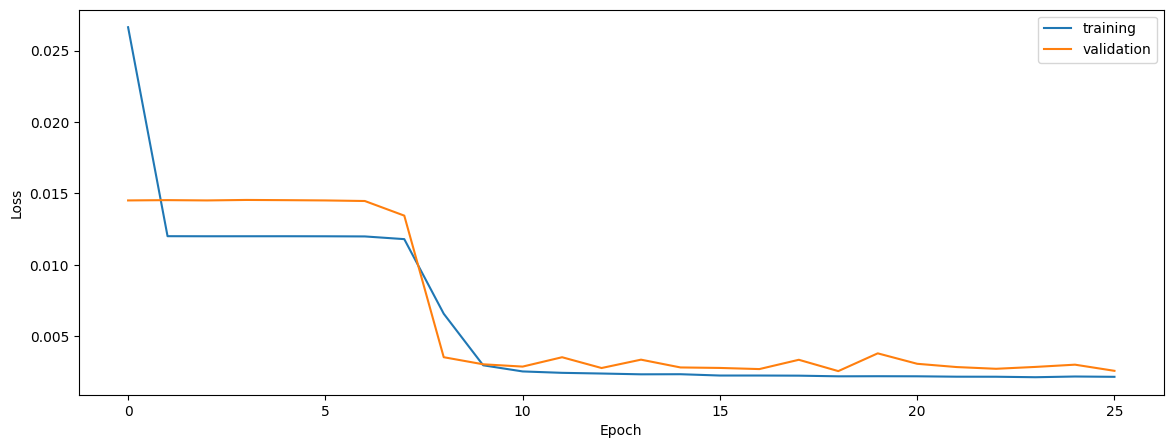

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9053985583985599
0.9111630094795308
0.9193985658419156


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9053985583985599
0.9111630094795308
0.9193985658419156


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9051402002366207
0.9130752196053488
0.9260336224195995


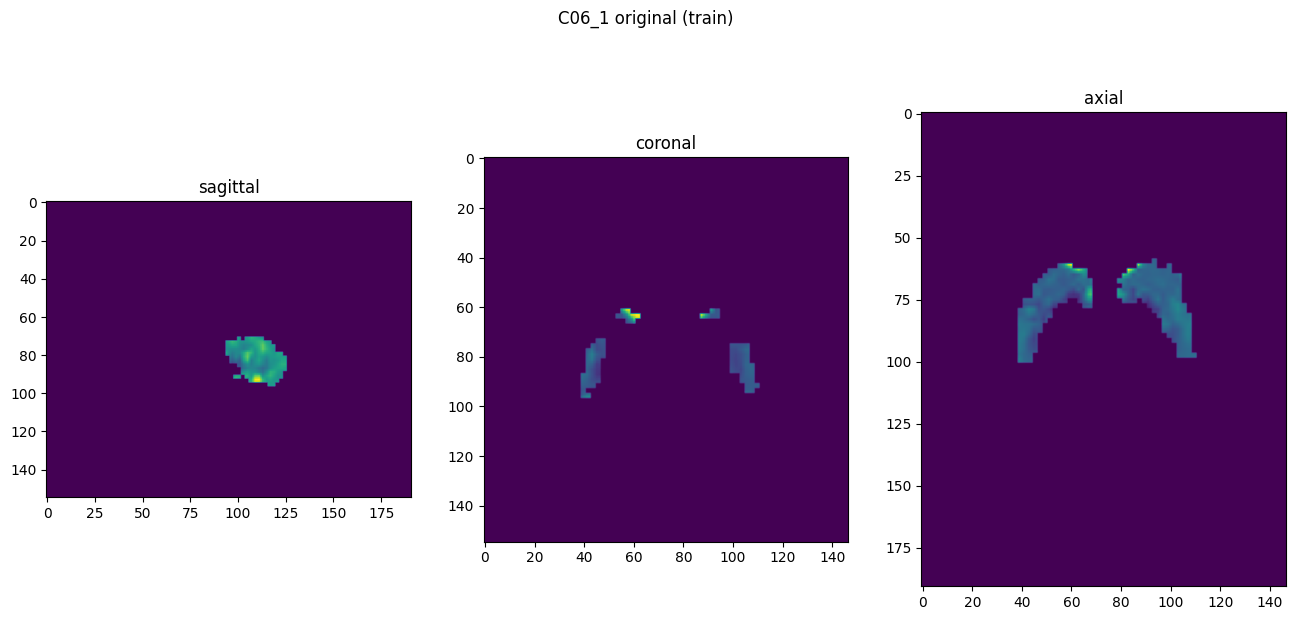

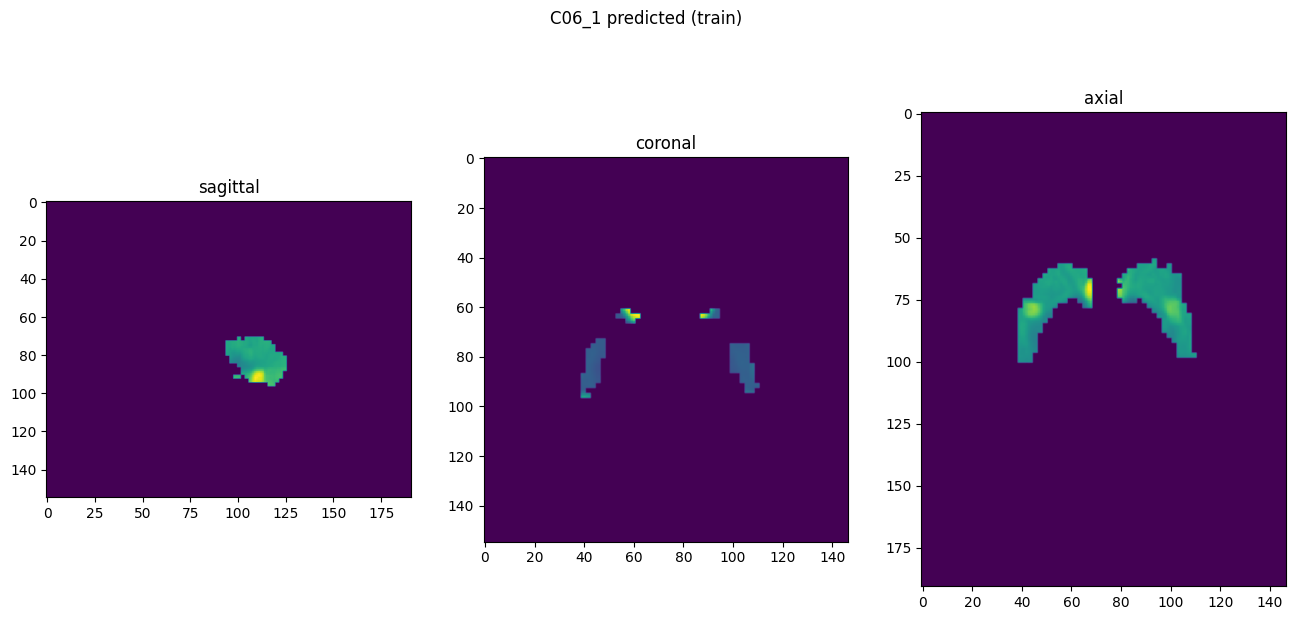

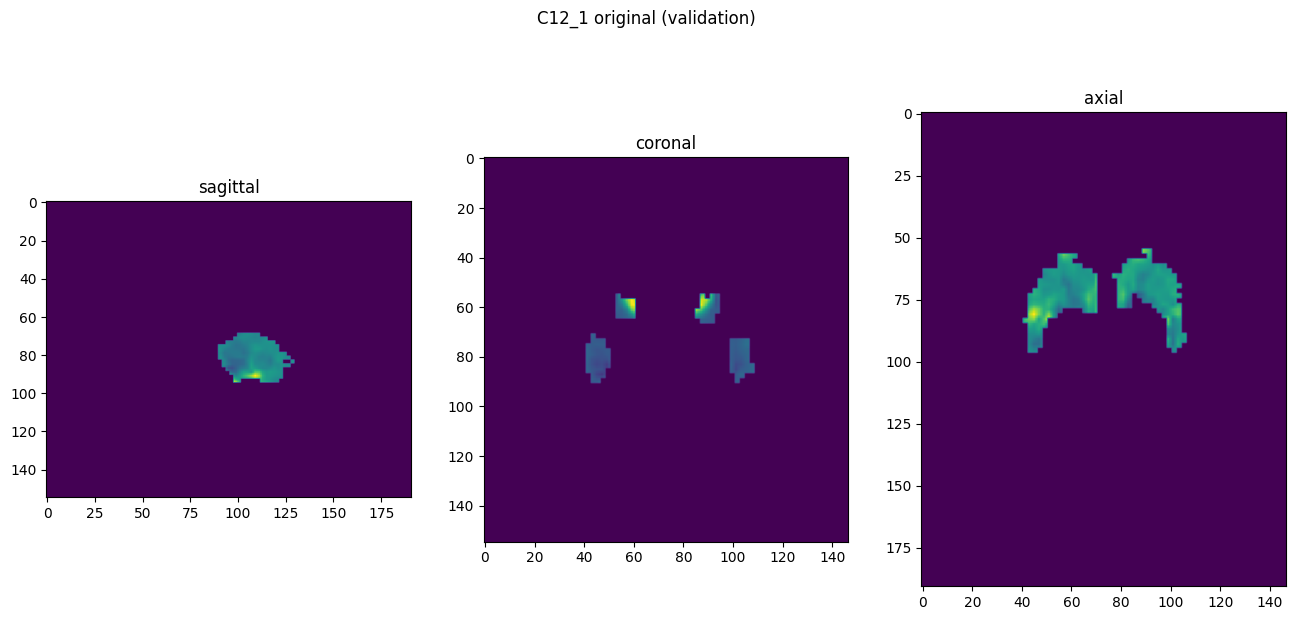

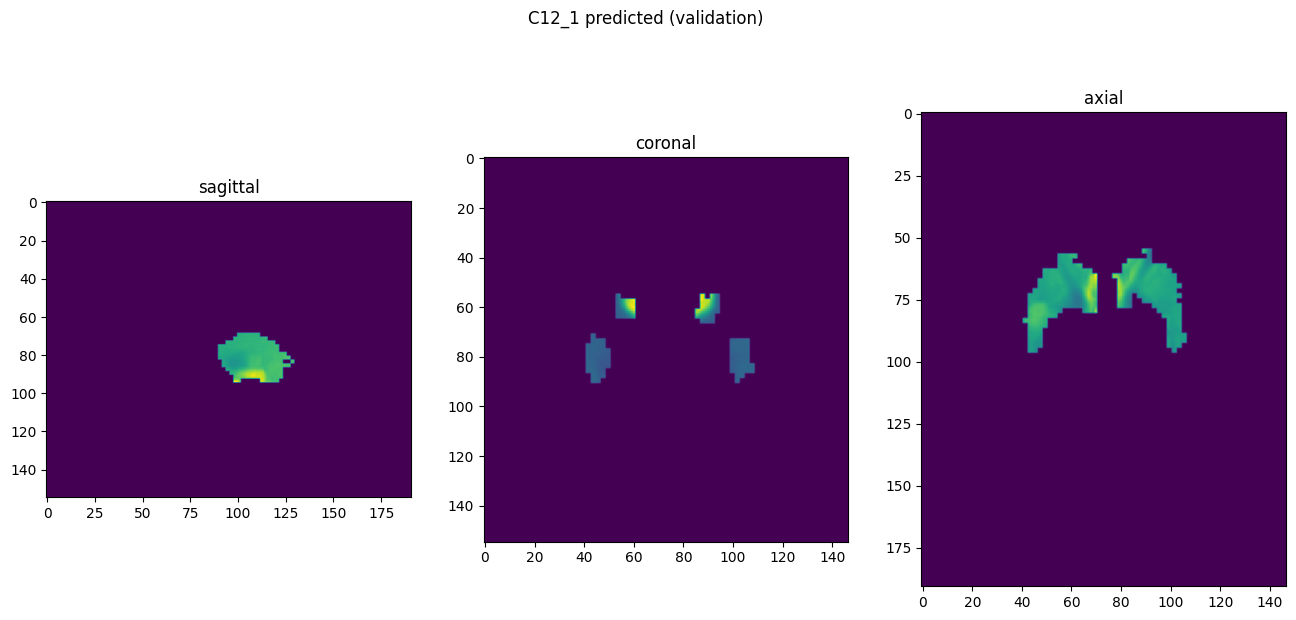

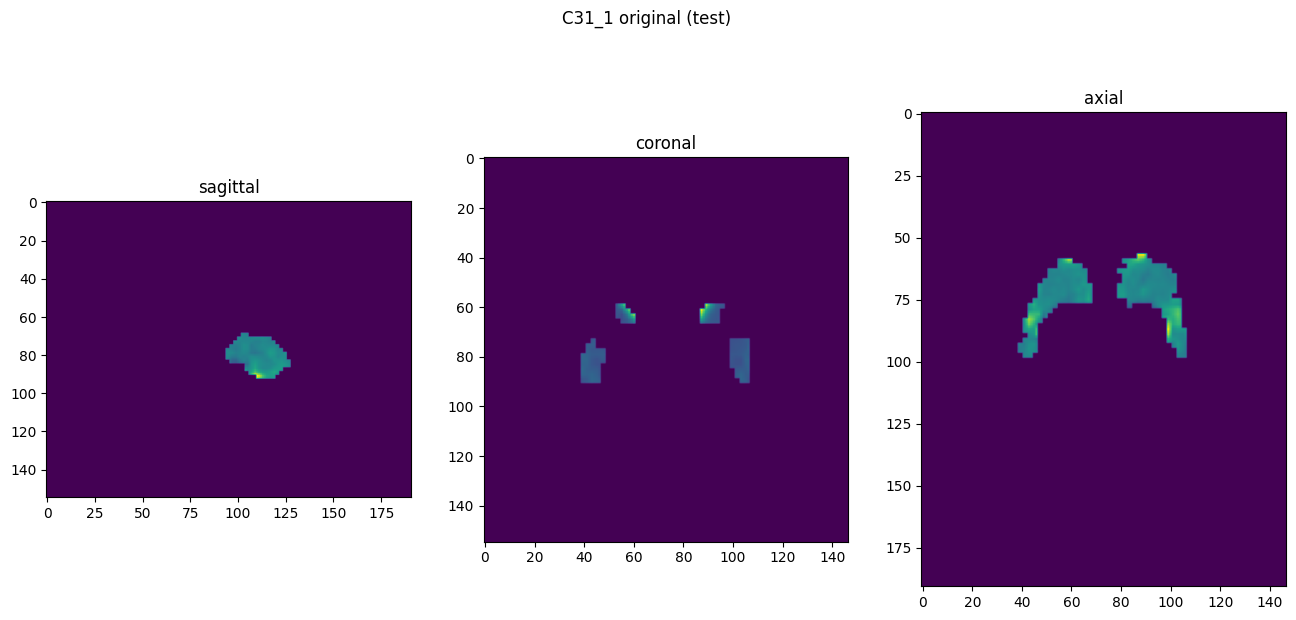

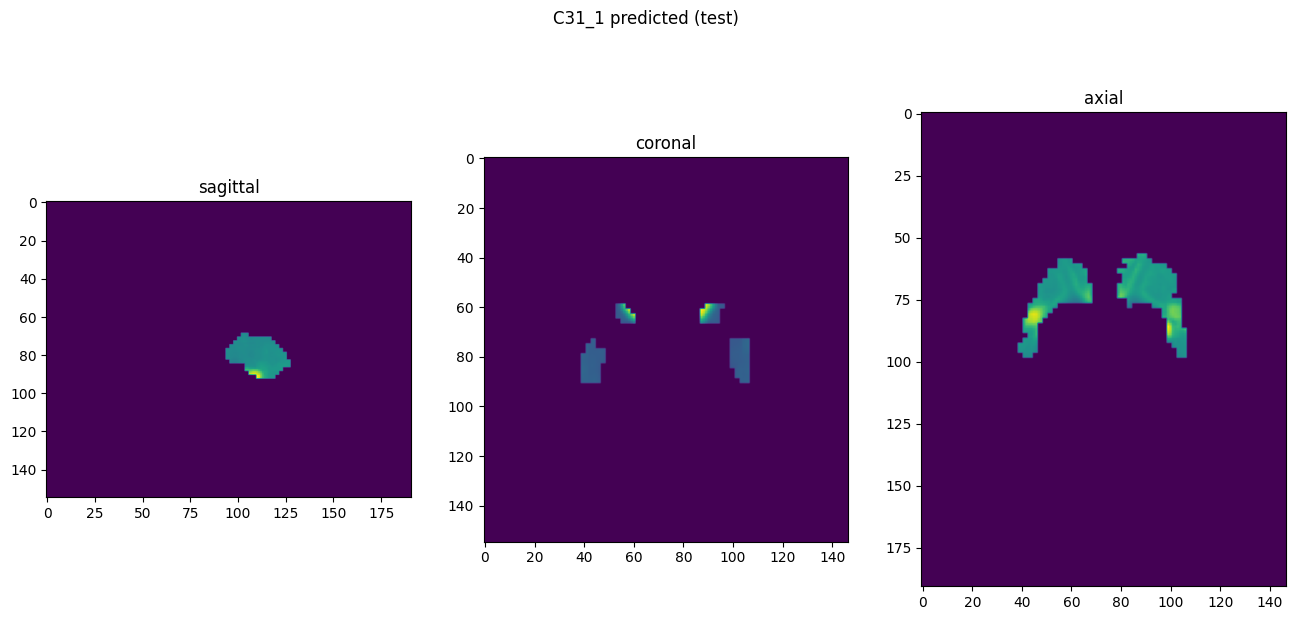

In [10]:
showResults(model, gen, threshold=None, background=False)